In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [2]:
def Carlsten(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

def calcHGamma(a, b, gamma):
    exp1 = (1-a) / (a * (1 - np.exp(-b)))
    exp2 = np.power(1-a, 2) * (2-gamma)
    exp3 = a * (1-a)
    return (exp1 + exp2 + exp3)

def calcAGamma(a, b, gamma):
    exp1 = np.exp(-b) / (a * (1-np.exp(-b)))
    exp2 = 2 - a + ((2-a)/(1-a))
    exp3 = np.power(1-a, 2) * gamma / a
    exp4 = np.power(a,2) / ((1-2*a)*(1-a))
    return a * (exp1 + exp2 + exp3 + exp4)

def calcAOverAHGamma(a, b, gamma):
    return calcAGamma(a,b,gamma) / (calcAGamma(a,b,gamma) + calcHGamma(a,b,gamma))

def Ours(a, b, gamma, scale=1):
    return (scale*Carlsten(alpha=a, beta=b, gamma=gamma) + calcAOverAHGamma(a=a, b=b, gamma=gamma)) / (scale + 1)

# 3d plot showing best beta-cutoff value vs. selfish curve vs honest

In [3]:
# first, theoretical
alpha  = 0.3
betas  = np.arange(0.01, 10.01, 0.01)
gammas = np.arange(0, 1.01, 0.01)
scales = [1/10, 1, 10]
bCutoffRews = []
selifhsRews = []
for scale in tqdm(scales):
    temp = []
    for g in gammas:
        temp.append(np.array([Ours(a=alpha, b=b, gamma=g, scale=scale) for b in betas]))
    bCutoffRews.append(temp)
bCutoffRews = np.array(bCutoffRews)
bCutoffRews.shape

100%|██████████| 3/3 [00:14<00:00,  4.97s/it]


(3, 101, 1000)

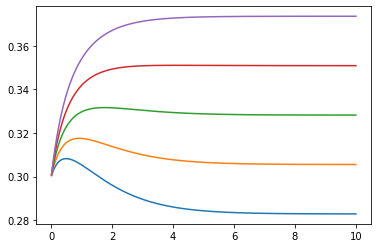

In [55]:
plt.plot(betas, bCutoffRews[0])
plt.plot(betas, bCutoffRews[25])
plt.plot(betas, bCutoffRews[50])
plt.plot(betas, bCutoffRews[75])
plt.plot(betas, bCutoffRews[100])

In [4]:
betas, gammas = np.meshgrid(betas, gammas)
betas.shape, gammas.shape

((101, 1000), (101, 1000))

In [6]:
bCutoffRews[0].shape

(101, 1000)

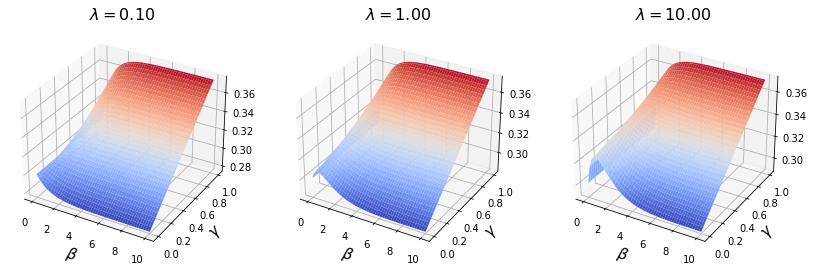

In [9]:
f, axarr = plt.subplots(ncols=3, figsize=(14,5), subplot_kw={"projection": "3d"})

for i in range(3):
    axarr[i].plot_surface(betas, gammas, bCutoffRews[i], cmap=mpl.cm.coolwarm)
    axarr[i].set_title(r'$\lambda=${:0.2f}'.format(scales[i]), size=16)
    
for ax in axarr:
    ax.set_xlabel(r'$\beta$', size=15)
    ax.set_ylabel(r'$\gamma$', size=15)

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [24]:
# R_f general
a, b, g = sp.symbols('alpha beta gamma')

A_expr = a * (sp.exp(-b) / (a*(1-sp.exp(-b))) + 2 - a + ((2-a)/(1-a)) + ((((1-a)**2)*g)/a) + (a**2/((1-2*a)*(1-a))))
H_expr = (1-a) / (a*(1-sp.exp(-b))) + ((1-a)**2)*(2-g) + a*(1-a)

R_f = A_expr / (A_expr + H_expr)

In [25]:
simplified_Rf = sp.simplify(R_f)
simplified_Rf

alpha*(2*alpha**3*gamma*exp(beta) - 2*alpha**3*gamma - 2*alpha**3*exp(beta) + 2*alpha**3 - 5*alpha**2*gamma*exp(beta) + 5*alpha**2*gamma + 8*alpha**2*exp(beta) - 8*alpha**2 + 4*alpha*gamma*exp(beta) - 4*alpha*gamma - 4*alpha*exp(beta) + 6*alpha - gamma*exp(beta) + gamma - 1)/(alpha**3*exp(beta) - alpha**3 + alpha**2*exp(beta) - alpha**2 + alpha*exp(beta) + alpha - exp(beta))

In [27]:
# R_e general
expr1 = (1 + b * ((1-a)**2)*(1-g)) / (sp.exp(b)-1) + 5*a + ((1-a)**2)*g + 2*(a**2)/(1-2*a) - 2*(a**2)
expr2 = (a*(1-2*a)*(1-sp.exp(-b))) / (1-2*sp.exp(-b)*a-3*(1-sp.exp(-b))*(a**2))

R_e = expr1 * expr2
simplified_Re = sp.simplify(R_e)
simplified_Re

alpha*(2*alpha**2*(1 - exp(beta)) - (1 - exp(beta))*(2*alpha - 1)*(-2*alpha**2 + 5*alpha + gamma*(alpha - 1)**2) + (2*alpha - 1)*(-beta*(alpha - 1)**2*(gamma - 1) + 1))/(-3*alpha**2*(1 - exp(beta)) + 2*alpha - exp(beta))

In [28]:
l = sp.symbols('lambda')
R_t = (simplified_Rf + l * simplified_Re) / (l + 1)
simplified_Rt = sp.simplify(R_t)
simplified_Rt

alpha*(-lambda*(2*alpha**2*(1 - exp(beta)) - (1 - exp(beta))*(2*alpha - 1)*(-2*alpha**2 + 5*alpha + gamma*(alpha - 1)**2) - (2*alpha - 1)*(beta*(alpha - 1)**2*(gamma - 1) - 1))*(alpha**3*exp(beta) - alpha**3 + alpha**2*exp(beta) - alpha**2 + alpha*exp(beta) + alpha - exp(beta)) - (3*alpha**2*(1 - exp(beta)) - 2*alpha + exp(beta))*(-2*alpha**3*gamma*exp(beta) + 2*alpha**3*gamma + 2*alpha**3*exp(beta) - 2*alpha**3 + 5*alpha**2*gamma*exp(beta) - 5*alpha**2*gamma - 8*alpha**2*exp(beta) + 8*alpha**2 - 4*alpha*gamma*exp(beta) + 4*alpha*gamma + 4*alpha*exp(beta) - 6*alpha + gamma*exp(beta) - gamma + 1))/((lambda + 1)*(3*alpha**2*(1 - exp(beta)) - 2*alpha + exp(beta))*(alpha**3*exp(beta) - alpha**3 + alpha**2*exp(beta) - alpha**2 + alpha*exp(beta) + alpha - exp(beta)))

In [30]:
lim = sp.limit(simplified_Rt, b, sp.oo)

In [31]:
print(lim.evalf(subs={l:1., a:0.3, g:1.00})) 

0.373575037007448


In [34]:
Ours(a=0.3, b=35, gamma=1., scale=1.)

0.37357503700744843

In [29]:
simplified_Rt.evalf(subs={l:1., a:0.3, g:1.0})

0.15*(-1.0*(0.183 - 0.583*exp(beta))*(0.504 - 0.904*exp(beta)) - (0.73*exp(beta) - 0.33)*(0.73*exp(beta) - 0.33))/((0.183 - 0.583*exp(beta))*(0.73*exp(beta) - 0.33))